# Домащнее задание 2

## Бейзлайны, Детерминированные алгоритмы

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix, coo_matrix

# Детерминированные алгоритмы
from implicit.nearest_neighbours import ItemItemRecommender, CosineRecommender, TFIDFRecommender, BM25Recommender

# Метрики
from implicit.evaluation import train_test_split
from implicit.evaluation import precision_at_k, mean_average_precision_at_k, AUC_at_k, ndcg_at_k

In [2]:
data = pd.read_csv('../data/retail_train.csv')
data.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [3]:
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

### Задание 1. Weighted Random Recommendation

Напишите код для случайных рекоммендаций, в которых вероятность рекомендовать товар прямо пропорциональна логарифму продаж
- Можно сэмплировать товары случайно, но пропорционально какому-либо весу
- Например, прямопропорционально популярности. Вес = log(sales_sum товара)

In [4]:
def weighted_random_recommendation(items_weights, n=5):
    """Случайные рекоммендации
    
    Input
    -----
    items_weights: pd.DataFrame
        Датафрейм со столбцами item_id, weight. Сумма weight по всем товарам = 1
    """
    
    # Подсказка: необходимо модифицировать функцию random_recommendation()
    # your_code

    recs = np.random.choice(items_weights.item_id,
                            p=items_weights.weight, 
                            size=n,
                            replace=False)

    return recs.tolist()

In [5]:
def get_weight_matrix(data):
    """Случайные рекоммендации
    
    Input
    -----
    data: pd.DataFrame
        Датафрейм со столбцами item_id, sales_value.

    Output
    -----
    items_weights
        Датафрейм со столбцами item_id, weight. Вес weight пропорционален лагорифму от объема продаж.
    """

    # Товары с рейтингом популярности.
    items_weights = data.groupby('item_id')['sales_value'].sum().reset_index()

    # Логарифм от объема продаж. Для товаров с суммой покупки меньше 1$ считаем вероятность купить этот товар равной нулю.
    log_sales_value = items_weights.sales_value.apply(lambda x: 0 if x < 1 else np.log(x))

    # Сумма log_sales_value по всем товарам.
    log_sales_value_sum = log_sales_value.sum()

    # Расчет веса товара по популярности.
    items_weights['weight'] = log_sales_value.apply(lambda x: x / log_sales_value_sum)

    return items_weights

In [6]:
%%time

# your_code

items_weights = get_weight_matrix(data)
items_weights.head() 

CPU times: user 156 ms, sys: 8.83 ms, total: 165 ms
Wall time: 164 ms


,item_id,sales_value,weight
0,25671,20.94,0.000013
1,26081,0.99,0.000000
2,26093,1.59,0.000002
3,26190,1.54,0.000002
4,26355,1.98,0.000003


Проверим правильность расчета весов.

In [7]:
items_weights.weight.sum()

0.9999999999999999

Сформируем датафрейм для сохранения всех результатов.

In [8]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


Добавим взвешенные случайные рекомендации к итоговому датафрейму.

In [9]:
%%time

result['weighted_random_recommendation'] = result['user_id'].apply(lambda x: weighted_random_recommendation(items_weights, n=5))
result.head(2)

CPU times: user 1.7 s, sys: 5.03 ms, total: 1.7 s
Wall time: 1.7 s


,user_id,actual,weighted_random_recommendation
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[924192, 12695656, 6602565, 7442056, 7442091]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1076281, 12987987, 853293, 12778101, 9858920]"


### Задание 2. Расчет метрик
Рассчитайте Precision@5 для каждого алгоритма с помощью функции из вебинара 1. Какой алгоритм показывает лучшее качество?

Здесь для ускорения процесса и для сохранения различных алгоритмов в истории (в git репозитории), скопируем методы из методички и проведём рассчет датафрейма `results`.  

### Random recommendation

In [10]:
def random_recommendation(items, n=5):
    """Случайные рекоммендации"""

    items = np.array(items)
    recs = np.random.choice(items, size=n, replace=False)
    
    return recs.tolist()

In [11]:
%%time

items = data.item_id.unique()

result['random_recommendation'] = result['user_id'].apply(lambda x: random_recommendation(items, n=5))
result.head(2)

CPU times: user 2.7 s, sys: 8 ms, total: 2.71 s
Wall time: 2.71 s


,user_id,actual,weighted_random_recommendation,random_recommendation
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[924192, 12695656, 6602565, 7442056, 7442091]","[9705603, 950575, 994807, 10203825, 1024858]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1076281, 12987987, 853293, 12778101, 9858920]","[8249236, 1068934, 1124976, 9337582, 8116442]"


### Popularity-based recommendation

In [12]:
def popularity_recommendation(data, n=5):
    """Топ-n популярных товаров"""
    
    popular = data.groupby('item_id')['sales_value'].sum().reset_index()
    popular.sort_values('sales_value', ascending=False, inplace=True)
    
    recs = popular.head(n).item_id
    
    return recs.tolist()

In [13]:
%%time

# Можно так делать, так как рекомендация не зависит от юзера
popular_recs = popularity_recommendation(data, n=5)

result['popular_recommendation'] = result['user_id'].apply(lambda x: popular_recs)
result.head(2)

CPU times: user 89.1 ms, sys: 266 µs, total: 89.4 ms
Wall time: 88.9 ms


,user_id,actual,weighted_random_recommendation,random_recommendation,popular_recommendation
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[924192, 12695656, 6602565, 7442056, 7442091]","[9705603, 950575, 994807, 10203825, 1024858]","[6534178, 6533889, 1029743, 6534166, 1082185]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1076281, 12987987, 853293, 12778101, 9858920]","[8249236, 1068934, 1124976, 9337582, 8116442]","[6534178, 6533889, 1029743, 6534166, 1082185]"


### Item-Item Recommender / ItemKNN

In [14]:
popularity = data.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

popularity.head()

,item_id,n_sold
0,25671,6
1,26081,1
2,26093,1
3,26190,1
4,26355,2


In [15]:
top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

In [16]:
# Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity',
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix[user_item_matrix > 0] = 1 # так как в итоге хотим предсказать 
user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

/home/alex/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15926775,15926844,15926885,15926886,15926927,15927403,15927661,15927850,16809471,17105257
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
user_item_matrix.shape

(2499, 5001)

In [18]:
# Разреженность матрицы.
user_item_matrix.sum().sum() / (user_item_matrix.shape[0] * user_item_matrix.shape[1]) * 100

5.335435513937629

In [19]:
# Словари для преобразования id

userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [20]:
%%time

model = ItemItemRecommender(K=5, num_threads=4) # K - кол-во билжайших соседей

model.fit(csr_matrix(user_item_matrix).T.tocsr(), show_progress=True)  # На вход item-user matrix


CPU times: user 1.7 s, sys: 13.1 ms, total: 1.72 s
Wall time: 597 ms


In [21]:
%%time

result['itemitem'] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=True, 
                                    filter_items=None, 
                                    recalculate_user=True)])

CPU times: user 98.7 ms, sys: 1.04 ms, total: 99.8 ms
Wall time: 74.1 ms


In [22]:
result.head(2)

,user_id,actual,weighted_random_recommendation,random_recommendation,popular_recommendation,itemitem
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[924192, 12695656, 6602565, 7442056, 7442091]","[9705603, 950575, 994807, 10203825, 1024858]","[6534178, 6533889, 1029743, 6534166, 1082185]","[981760, 1127831, 1098066, 826249, 878996]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1076281, 12987987, 853293, 12778101, 9858920]","[8249236, 1068934, 1124976, 9337582, 8116442]","[6534178, 6533889, 1029743, 6534166, 1082185]","[981760, 995242, 1029743, 840361, 961554]"


### CosineRecommender

In [23]:
%%time

model = CosineRecommender(K=5, num_threads=4) # K - кол-во билжайших соседей

model.fit(csr_matrix(user_item_matrix).T.tocsr(), show_progress=True)


CPU times: user 1.5 s, sys: 6.34 ms, total: 1.51 s
Wall time: 552 ms


In [24]:
%%time

result['cosine'] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=True, 
                                    filter_items=None, 
                                    recalculate_user=True)])

CPU times: user 88.3 ms, sys: 825 µs, total: 89.1 ms
Wall time: 69.8 ms


In [25]:
result.head(2)

,user_id,actual,weighted_random_recommendation,random_recommendation,popular_recommendation,itemitem,cosine
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[924192, 12695656, 6602565, 7442056, 7442091]","[9705603, 950575, 994807, 10203825, 1024858]","[6534178, 6533889, 1029743, 6534166, 1082185]","[981760, 1127831, 1098066, 826249, 878996]","[981760, 1127831, 1098066, 878996, 826249]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1076281, 12987987, 853293, 12778101, 9858920]","[8249236, 1068934, 1124976, 9337582, 8116442]","[6534178, 6533889, 1029743, 6534166, 1082185]","[981760, 995242, 1029743, 840361, 961554]","[981760, 1004906, 961554, 1096036, 1080414]"


### TFIDFRecommender

In [26]:
%%time

model = TFIDFRecommender(K=5, num_threads=4) # K - кол-во билжайших соседей

model.fit(csr_matrix(user_item_matrix).T.tocsr(), show_progress=True)


CPU times: user 1.48 s, sys: 4.19 ms, total: 1.48 s
Wall time: 514 ms


In [27]:
%%time

result['tfidf'] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=True, 
                                    filter_items=None, 
                                    recalculate_user=False)])

CPU times: user 97.4 ms, sys: 204 µs, total: 97.6 ms
Wall time: 68 ms


In [28]:
result.head(2)

,user_id,actual,weighted_random_recommendation,random_recommendation,popular_recommendation,itemitem,cosine,tfidf
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[924192, 12695656, 6602565, 7442056, 7442091]","[9705603, 950575, 994807, 10203825, 1024858]","[6534178, 6533889, 1029743, 6534166, 1082185]","[981760, 1127831, 1098066, 826249, 878996]","[981760, 1127831, 1098066, 878996, 826249]","[981760, 1127831, 1098066, 826249, 878996]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1076281, 12987987, 853293, 12778101, 9858920]","[8249236, 1068934, 1124976, 9337582, 8116442]","[6534178, 6533889, 1029743, 6534166, 1082185]","[981760, 995242, 1029743, 840361, 961554]","[981760, 1004906, 961554, 1096036, 1080414]","[981760, 1004906, 859075, 1096036, 961554]"


### Рекомендации среди уже купленных товаров

In [29]:
%%time

model = ItemItemRecommender(K=1, num_threads=4) # K - кол-во билжайших соседей

model.fit(csr_matrix(user_item_matrix).T.tocsr(), show_progress=True)


CPU times: user 1.41 s, sys: 4.35 ms, total: 1.41 s
Wall time: 493 ms


In [30]:
%%time

result['own_purchases'] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=[999999], 
                                    recalculate_user=False)])

CPU times: user 76.4 ms, sys: 669 µs, total: 77.1 ms
Wall time: 44.1 ms


In [31]:
result.head(2)

,user_id,actual,weighted_random_recommendation,random_recommendation,popular_recommendation,itemitem,cosine,tfidf,own_purchases
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[924192, 12695656, 6602565, 7442056, 7442091]","[9705603, 950575, 994807, 10203825, 1024858]","[6534178, 6533889, 1029743, 6534166, 1082185]","[981760, 1127831, 1098066, 826249, 878996]","[981760, 1127831, 1098066, 878996, 826249]","[981760, 1127831, 1098066, 826249, 878996]","[999999, 1082185, 1029743, 995785, 1004906]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1076281, 12987987, 853293, 12778101, 9858920]","[8249236, 1068934, 1124976, 9337582, 8116442]","[6534178, 6533889, 1029743, 6534166, 1082185]","[981760, 995242, 1029743, 840361, 961554]","[981760, 1004906, 961554, 1096036, 1080414]","[981760, 1004906, 859075, 1096036, 961554]","[999999, 1082185, 1098066, 6534178, 1127831]"


Итоговый датафрейм сформирован, далее посчитаем метрику `Precision@5`.

In [32]:
# your_code

In [33]:

def precision_at_k(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    
    bought_list = bought_list  # Тут нет [:k] !!
    recommended_list = recommended_list[:k]
    
    flags = np.isin(bought_list, recommended_list)
    
    precision = flags.sum() / len(recommended_list)
    
    return precision

In [34]:
def average_precision_at_k(recommended_matrix, bought_matrix, k=5):
    
    rows_count = bought_matrix.shape[0]
    precisions_by_row = [precision_at_k(recommended_matrix[i], bought_matrix[i], k) for i in range(rows_count)]
    precisions_mean = np.mean(precisions_by_row)

    return precisions_mean

In [35]:
# все ранее расчитанные алгоритмы
columns = result.columns.drop(['user_id', 'actual'])

for column in columns:
    precisions_mean = average_precision_at_k(result[column], result.actual, k=5)
    print('{:35} {:.4f} %'.format(column, precisions_mean * 100))

weighted_random_recommendation      0.1273 %
random_recommendation               0.0392 %
popular_recommendation              15.5240 %
itemitem                            3.4084 %
cosine                              3.5847 %
tfidf                               3.5945 %
own_purchases                       17.9693 %


Наилучшее качество показывает бейзлайн алгоритм рекомендации товаров среди ранее купленных. Похожая точность у алгоритма рекомендации по популярности товара. Этот алгоритм не зависит от пользователя и рекомендует всем одни и те же товары. 

Алгоритм рекомендации случайного товара показал меньшую точность, чем алгоритм с учетом весов товаров по объемам продаж.  

### Задание 3*. Улучшение бейзлайнов и ItemItem

- Попробуйте улучшить бейзлайны, считая их на топ- {2000, 5000, 10000} товаров. Постройте график зависимости precision@5 от топ-*
- Попробуйте улучшить разные варианты ItemItemRecommender, выбирая число соседей $K$. Постройте график зависимости precision@5 от $K$ 

In [514]:
# your_code

#### Тюнинг бейзлайн моделей.

In [42]:
top_items_count_list = np.arange(1000, 11000, 1000)

_data = data_test.groupby('user_id')['item_id'].unique().reset_index()
actual = _data.item_id
user_ids = _data.user_id
popular_recs = popularity_recommendation(data, n=5)

# списки результатов для разных значений топ-k товаров
result_random_recommendation = []
result_popular_recommendation = []
result_weighted_random_recs = []

for top_items_count in top_items_count_list:
    top_items_ids = data \
        .groupby('item_id')['quantity'] \
        .sum() \
        .reset_index() \
        .sort_values('quantity', ascending=False) \
        .head(top_items_count) \
        .item_id.tolist()

    # случайные рекомендации
    random_recommendations = [random_recommendation(top_items_ids, n=5) for user_id in user_ids]
    precisions_mean = average_precision_at_k(random_recommendations, actual, k=5)
    result_random_recommendation.append(precisions_mean)
    
    # рекомендация топ-5 товаров всем пользователям
    popular_recomendations = [popular_recs for user_id in user_ids]
    precisions_mean = average_precision_at_k(popular_recomendations, actual, k=5)
    result_popular_recommendation.append(precisions_mean)

    # взвешенные случайные рекомендации
    items_weights = get_weight_matrix(data.loc[data['item_id'].isin(top_items_ids), :])
    weighted_random_recommendations = [weighted_random_recommendation(items_weights, n=5) for user_id in user_ids]
    precisions_mean = average_precision_at_k(weighted_random_recommendations, actual, k=5)
    result_weighted_random_recs.append(precisions_mean)


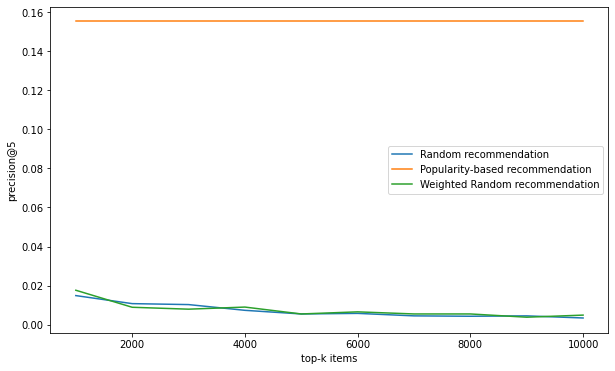

In [43]:
plt.figure(figsize=(10, 6))

plt.plot(top_items_count_list, result_random_recommendation, label="Random recommendation")
plt.plot(top_items_count_list, result_popular_recommendation, label="Popularity-based recommendation")
plt.plot(top_items_count_list, result_weighted_random_recs, label="Weighted Random recommendation")
plt.xlabel('top-k items')
plt.ylabel('precision@5')
plt.legend()
plt.show()

Качество рекомендательной модели по популярным товарам не зависит от величины списка топ-k товаров. Это связано с тем что список топ 5 товаров, которые мы рекомендуем, не меняется от `k`.

Качество моделей, завязанных на случайном выборе, с ростом списка топ-k товаров уменьшается. Это связано с тем что вероятность порекомендовать определёный товар уменьшается с ростом `k`. А в большинстве своём пользователи покупают популярные товары. Поэтому в случайный список эти популярные товары попадают всё реже и реже. 

#### Тюнинг модели ItemItemRecomender.

In [44]:
# Результат precision@5 для всех значений K.
result_user_item = []

# Перебираемые значения K.
k_list = np.arange(1, 11)

for k in k_list:
    model = ItemItemRecommender(K=k, num_threads=4)
    model.fit(csr_matrix(user_item_matrix).T.tocsr(), show_progress=True)

    # Инициализируем матрицу рекомендаций.
    recomended_matrix = []

    # Считаем рекомендации для каждого покупателя.
    for userid in result.user_id:
        recomends = model.recommend(userid=userid_to_id[userid], 
                                    user_items=sparse_user_item,
                                    N=5, 
                                    filter_already_liked_items=True, 
                                    filter_items=None, 
                                    recalculate_user=True)
        recomended_matrix.append([id_to_itemid[rec[0]] for rec in recomends])

    precisions_mean = average_precision_at_k(recomended_matrix, result.actual, k=5)
    result_user_item.append(precisions_mean)

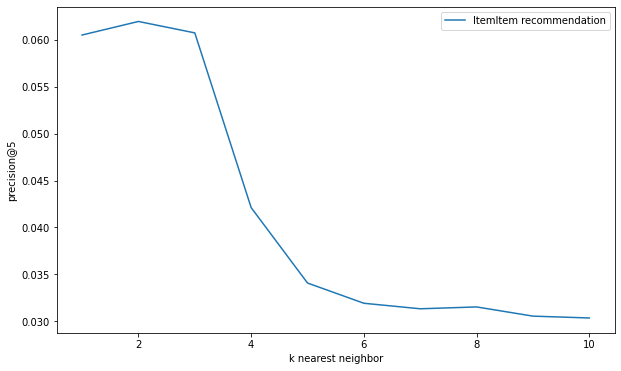

In [45]:
plt.figure(figsize=(10, 6))

plt.plot(k_list, result_user_item, label="ItemItem recommendation")
plt.xlabel('k nearest neighbor')
plt.ylabel('precision@5')
plt.legend()
plt.show()

#### Выводы

При тюнинге бейзлайн моделей расчет приводился для всех пользователей, без деления на тренировочную и тестовую выборки. Как я понял, при исбользовании бейзлайнов это делать не обязательно. На вебинаре делали только для тестовой выборки чтобы сравнить результат с детерменированными алгоритмами. Поправьте пожалуйста, если я ошибся.

При тюнинге ItemItemRecomender результат можно сравнивать с предыдущими расчетами, так как тюнинг проводился на тестовой выборке. При K=5 видим результат как и раньше около 3,5%. Но лучший результат достигается при уменьшении числа ближайших соседей до 2. 

Так же везде по коду при расчете параметров продуктов (при расчете рейтинга популярных товаров) я брал весь датасет, без выделения продуктов, которые покупали только пользователи в тестовой выборке. Мне кажется что предпочтения в покупках не должны зависеть от разбиения датафрейма. Это ещё сделано чтобы исключить кейс, когда в тестовой выборке купили товар, который никогда не покупали в тренировочной выборке. Скажите пожалуйста, это правильный подход?  